In [5]:
import os
import sys
import pandas as pd
import networkx as nx
from collections import defaultdict

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def alpha_for_two_followers(df, f1, f2):
    ratios = df.apply(lambda col: min(col[f1], col[f2]) / max(col[f1], col[f2]))
    # if ratios.min() < 0.5: print(ratios)
    return ratios.min()
    
def compute_alpha(row, instance_directory):
    clusters = [[] for i in range(row['policies'])]
    assignments = row['GREEDY_partition'].split('-')
    follower = 0
    instance_name = row['instance_name']
    instance_file = instance_name.split('-')[0] + '-' + instance_name.split('-')[1] + '-costs_' + instance_name.split('-')[2] + '.csv' 
    df = pd.read_csv(os.path.join(instance_directory, instance_file), header=None)
    alpha = sys.maxsize
    for a in assignments:
        clusters[int(a)].append(follower)
        follower+=1
    for c in clusters:
        for i in range(len(c)):
            for j in range(i+1, len(c)):
                val = alpha_for_two_followers(df, c[i], c[j])
                if val < alpha: alpha = val 
    return alpha

def add_alpha(df, exp_name):
    instance_directory = os.path.join('instances', exp_name)
    
    # Iterate through each row and compute the value for the new column
    new_column = []
    for index, row in df.iterrows():
        new_value = compute_alpha(row, instance_directory)
        new_column.append(new_value)

    # Add the new column to the DataFrame
    df['alpha'] = new_column
    
    return df

def remove_arcs_not_in_paths(df, instance_directory, graph_file):
    G = nx.DiGraph()
    linked_list_arc_indices = defaultdict(dict)
    
    # Read the graph from the file
    with open(os.path.join(instance_directory, graph_file), "r") as file:
        a = 0
        for line in file:
            line = line.strip()
            u, v = map(int, line.split())
            G.add_edge(u, v)
            linked_list_arc_indices[u][v] = a
            a += 1
    
    # Find all simple paths in the graph
    all_paths = list(nx.all_simple_paths(G, source=0, target=max(G.nodes())))  # Replace START_NODE and END_NODE
    
    # Identify the columns to keep
    columns_to_keep = set()
    for path in all_paths:
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            a = linked_list_arc_indices[u][v]
            columns_to_keep.add(a)
    
    # Create a modified DataFrame with selected columns
    modified_df = df.iloc[:, list(columns_to_keep)]
    
    return modified_df  
    
    
def compute_alpha_bar(row, instance_directory):
    instance_name = row['instance_name']
    graph_file = instance_name.split('-')[0] + '-' + instance_name.split('-')[1] + ".txt"
    clusters = [[] for i in range(row['policies'])]
    assignments = row['GREEDY_partition'].split('-')
    follower = 0
    instance_name = row['instance_name']
    instance_file = instance_name.split('-')[0] + '-' + instance_name.split('-')[1] + '-costs_' + instance_name.split('-')[2] + '.csv' 
    df = pd.read_csv(os.path.join(instance_directory, instance_file), header=None)
    paths_only_df = remove_arcs_not_in_paths(df, instance_directory, graph_file)
    alpha = sys.maxsize
    for a in assignments:
        clusters[int(a)].append(follower)
        follower+=1
    for c in clusters:
        for i in range(len(c)):
            for j in range(i+1, len(c)):
                val = alpha_for_two_followers(paths_only_df, c[i], c[j])
                if val < alpha: alpha = val 
    return alpha

def add_alpha_bar(df, exp_name):
    instance_directory = os.path.join('instances', exp_name)
    
    # Iterate through each row and compute the value for the new column
    new_column = []
    for index, row in df.iterrows():
        new_value = compute_alpha_bar(row, instance_directory)
        new_column.append(new_value)

    # Add the new column to the DataFrame
    df['alpha'] = new_column
    
    return df

In [2]:
def compute_all_paths_total_costs(row, instance_directory, graph_file, instance_file):
        df = pd.read_csv(os.path.join(instance_directory, instance_file), header=None)
        followers = df.shape[0]
        G = nx.DiGraph()
        linked_list_arc_indices = defaultdict(dict)
        with open(os.path.join(instance_directory, graph_file), "r") as file:
            # Loop over each line in the file
            a = 0
            for line in file:
                # Strip the trailing newline character
                line = line.strip()
                # Split the line by space to get the values of u and v
                u, v = map(int, line.split())
                G.add_edge(u, v)
                linked_list_arc_indices[u][v] = a
                a += 1
        
        source = 0
        sink = max(G.nodes())
        all_paths_total_costs = []
        
        counter = 0
        for path in nx.all_simple_paths(G, source, sink):
            print("working on path ", counter)
            path_total_costs = []
            path_arc_indices = []
            for i in range(len(path)-1):
                u = path[i]
                v = path[i+1]
                path_arc_indices.append(linked_list_arc_indices[u][v])
            for q in range(followers):
                cost = 0
                for a in path_arc_indices:
                    cost += df.iloc[q, a]
                path_total_costs.append(cost)        
            all_paths_total_costs.append(path_total_costs)
            counter += 1
            
        return all_paths_total_costs
        
def compute_exact_alpha(row, all_paths_total_costs):
    clusters = [[] for i in range(row['policies'])]
    assignments = row['GREEDY_partition'].split('-')
    follower = 0
    alpha = sys.maxsize
    for a in assignments:
        clusters[int(a)].append(follower)
        follower+=1
    for c in clusters:
        for i in range(len(c)):
            for j in range(i+1, len(c)):
                for path in all_paths_total_costs:
                    val = min(path[i], path[j]) / max(path[i], path[j])
                    if val < alpha: alpha = val 
    return alpha
    
def add_exact_alpha(df, exp_name):
    instance_directory = os.path.join('instances', exp_name)
    
    # Iterate through each row and compute the value for the new column
    new_column = []
    all_paths_total_costs_dict = {}
    for index, row in df.iterrows():
        instance_name = row['instance_name']
        graph_file = instance_name.split('-')[0] + '-' + instance_name.split('-')[1] + ".txt"
        instance_file = instance_name.split('-')[0] + '-' + instance_name.split('-')[1] + '-costs_' + instance_name.split('-')[2] + '.csv'
        path_costs = all_paths_total_costs_dict.setdefault(graph_file, compute_all_paths_total_costs(row, instance_directory, graph_file, instance_file))
        new_value = compute_exact_alpha(row, path_costs)
        new_column.append(new_value)

    # Add the new column to the DataFrame
    df['alpha'] = new_column
    
    return df

In [2]:
EXP_NAME = 'experiment_layerratio-alpha'
#INSTANCES = os.path.join('instances', EXP_NAME)
EXP_FILE = EXP_NAME + '.csv'

In [8]:
exp = pd.read_csv(EXP_FILE)
# exp = add_alpha(exp, EXP_NAME)
# exp = add_exact_alpha(exp, EXP_NAME)
exp = add_alpha(exp, EXP_NAME)

0      0.913242
1      0.916279
2      0.930876
3      0.930876
4      0.955665
5      0.933333
6      0.903226
7      0.957672
8      0.938776
9      0.984375
10     0.948357
11     0.929245
12     0.994975
13     0.970297
14     0.985646
15     0.989796
16     0.967593
17     0.940594
18     0.985714
19     0.954774
20     0.989637
21     0.884615
22     0.931373
23     0.903226
24     0.889401
25     0.969388
26     0.942308
27     0.964467
28     0.979695
29     0.969388
30     0.995215
31     0.995215
32     0.966019
33     0.970732
34     0.345946
35     0.921182
36     0.995169
37     0.967890
38     0.910448
39     0.994872
40     0.836364
41     0.985714
42     0.985294
43     0.357488
44     0.948598
45     0.980488
46     0.936275
47     0.901042
48     0.884793
49     0.940887
50     0.965347
51     0.895735
52     0.918660
53     0.928571
54     0.994792
55     0.956098
56     0.862559
57     0.989474
58     0.939698
59     0.981221
60     0.989796
61     0.947368
62     0

0      0.954315
1      0.965517
2      0.903226
3      1.000000
4      0.910000
5      0.924171
6      0.965174
7      0.927536
8      0.995392
9      0.974619
10     0.903846
11     0.971698
12     0.979275
13     0.926471
14     0.979487
15     0.966019
16     0.931193
17     0.901869
18     0.922280
19     0.852018
20     0.917073
21     0.923810
22     0.915888
23     1.000000
24     0.875622
25     0.989950
26     0.928910
27     0.937824
28     0.942857
29     0.941748
30     0.980952
31     0.956098
32     0.893023
33     0.989899
34     0.963303
35     0.946602
36     0.995122
37     0.942584
38     0.964646
39     0.966507
40     0.829694
41     0.966981
42     0.924242
43     0.957547
44     0.915493
45     0.893720
46     0.232227
47     0.989899
48     0.984375
49     0.985075
50     0.967742
51     0.980392
52     0.985507
53     0.904306
54     0.893939
55     0.925000
56     0.985437
57     0.928230
58     0.970588
59     0.965517
60     0.961538
61     0.974619
62     0

0      0.985222
1      0.951456
2      0.928230
3      0.990148
4      0.956938
5      0.980861
6      1.000000
7      0.980296
8      0.926829
9      0.970149
10     0.935961
11     0.973262
12     0.983871
13     0.980488
14     0.994652
15     0.981651
16     0.941463
17     0.938679
18     0.878505
19     0.898148
20     0.969543
21     0.905000
22     0.964646
23     0.990244
24     0.882927
25     0.979487
26     0.937198
27     0.949495
28     0.890995
29     0.959184
30     0.975490
31     0.911765
32     0.932692
33     0.979899
34     0.946341
35     0.962791
36     0.985646
37     0.979167
38     0.947619
39     0.970732
40     0.928571
41     0.915000
42     0.920398
43     0.230047
44     0.980583
45     0.975962
46     0.960000
47     0.980000
48     0.916667
49     0.980769
50     0.984925
51     0.981481
52     0.989637
53     0.985000
54     0.967290
55     0.886139
56     0.936893
57     0.965174
58     0.956522
59     0.980198
60     0.990291
61     0.979899
62     0

0      0.985366
1      0.904110
2      0.947619
3      0.935644
4      0.936893
5      0.892683
6      0.960396
7      0.909091
8      0.962085
9      0.985000
10     0.942584
11     0.980676
12     0.966346
13     0.910798
14     0.971014
15     0.969072
16     0.966019
17     0.990050
18     0.939535
19     0.994949
20     0.994975
21     0.935323
22     0.941463
23     0.979695
24     0.937198
25     0.961905
26     0.866071
27     0.994845
28     0.945455
29     0.989744
30     0.904762
31     0.918660
32     0.887255
33     0.975248
34     0.858447
35     0.925926
36     0.971429
37     0.809524
38     0.974747
39     0.218182
40     0.955224
41     0.931034
42     0.966019
43     0.994924
44     0.924528
45     0.927536
46     0.994898
47     0.898551
48     0.966507
49     1.000000
50     0.970874
51     0.894737
52     0.979592
53     0.942408
54     0.946860
55     0.935644
56     0.904762
57     0.981132
58     0.925581
59     0.990244
60     0.990099
61     0.896714
62     0

0      0.990000
1      0.879070
2      0.926267
3      0.958525
4      0.955665
5      0.918367
6      0.870968
7      0.989418
8      0.928910
9      0.979592
10     0.981221
11     0.924528
12     0.989950
13     0.871111
14     1.000000
15     0.974874
16     0.925926
17     0.945545
18     0.975845
19     0.883721
20     0.958549
21     0.953368
22     0.990196
23     0.907834
24     0.903226
25     0.975124
26     1.000000
27     0.989848
28     0.955446
29     0.994924
30     0.884615
31     0.956731
32     0.956311
33     0.965854
34     0.344086
35     0.850000
36     0.912621
37     0.990521
38     0.966346
39     0.951220
40     0.948454
41     0.890476
42     0.975124
43     0.908213
44     0.841121
45     0.980488
46     0.995098
47     0.905759
48     0.912442
49     0.918269
50     0.890411
51     0.995283
52     0.976636
53     0.950226
54     0.842105
55     0.962441
56     0.947867
57     0.973684
58     0.980296
59     0.845070
60     0.839827
61     0.870813
62     0

0      1.000000
1      0.945813
2      0.903061
3      0.959596
4      0.870813
5      0.952607
6      0.948113
7      0.932039
8      0.884259
9      0.942584
10     0.990385
11     0.943396
12     0.863014
13     0.974227
14     0.927184
15     0.990050
16     0.944186
17     0.901869
18     0.917526
19     0.910314
20     0.944724
21     0.852381
22     0.911215
23     0.887324
24     0.921466
25     0.985149
26     0.989796
27     0.994819
28     0.857143
29     0.966019
30     0.917476
31     0.989899
32     1.000000
33     0.975124
34     0.885321
35     0.933014
36     0.995122
37     0.949239
38     0.974490
39     0.966507
40     0.864629
41     0.919811
42     0.217172
43     0.990244
44     0.972603
45     0.898058
46     0.252577
47     0.984694
48     0.926471
49     0.965854
50     0.971429
51     0.950000
52     0.888889
53     0.976636
54     0.880597
55     0.915842
56     0.950739
57     0.965174
58     0.990291
59     0.933333
60     0.932692
61     0.923077
62     0

0      0.990244
1      0.927184
2      0.979798
3      0.980296
4      0.947368
5      0.944700
6      0.963351
7      0.959799
8      0.959596
9      0.995025
10     0.990244
11     0.973958
12     0.953846
13     0.962441
14     0.958763
15     0.926606
16     0.979275
17     1.000000
18     0.901869
19     0.989796
20     1.000000
21     0.921659
22     0.969543
23     0.980488
24     0.947644
25     0.984615
26     0.898148
27     0.935323
28     0.962085
29     0.949495
30     0.969849
31     0.985507
32     0.927885
33     0.956731
34     0.960976
35     0.937198
36     0.956938
37     0.882629
38     0.919048
39     0.917073
40     0.919811
41     0.956938
42     0.973684
43     0.228972
44     0.951456
45     0.956731
46     0.917431
47     0.995025
48     0.897059
49     0.985782
50     0.994924
51     0.888889
52     0.979275
53     0.939086
54     0.957944
55     0.920792
56     0.953368
57     0.907216
58     0.980198
59     0.938389
60     0.962617
61     0.975490
62     0

0      0.954315
1      0.965517
2      0.903226
3      1.000000
4      0.910000
5      0.924171
6      0.965174
7      0.927536
8      0.995392
9      0.974619
10     0.903846
11     0.971698
12     0.979275
13     0.926471
14     0.979487
15     0.966019
16     0.931193
17     0.901869
18     0.922280
19     0.852018
20     0.917073
21     0.923810
22     0.915888
23     1.000000
24     0.875622
25     0.989950
26     0.928910
27     0.937824
28     0.942857
29     0.941748
30     0.980952
31     0.956098
32     0.893023
33     0.989899
34     0.963303
35     0.946602
36     0.995122
37     0.942584
38     0.964646
39     0.966507
40     0.829694
41     0.966981
42     0.924242
43     0.957547
44     0.915493
45     0.893720
46     0.232227
47     0.989899
48     0.984375
49     0.985075
50     0.967742
51     0.980392
52     0.985507
53     0.904306
54     0.893939
55     0.925000
56     0.985437
57     0.928230
58     0.970588
59     0.965517
60     0.961538
61     0.974619
62     0

0      0.964286
1      0.970149
2      0.880734
3      0.980583
4      0.973404
5      0.920792
6      0.968037
7      0.945274
8      0.979899
9      0.931034
10     0.995050
11     0.889447
12     0.942857
13     0.941176
14     0.985149
15     0.866359
16     0.989796
17     0.864253
18     0.905473
19     0.925743
20     0.887850
21     0.884615
22     0.845794
23     0.936585
24     0.989744
25     0.965000
26     0.978723
27     0.942857
28     0.995098
29     0.994949
30     0.950739
31     0.995122
32     0.989848
33     0.936893
34     0.940541
35     0.946341
36     0.877828
37     0.980296
38     0.900000
39     0.910526
40     0.914692
41     0.980000
42     0.985366
43     0.984925
44     0.894977
45     0.985782
46     0.960000
47     0.950495
48     0.970443
49     0.873171
50     0.964103
51     0.980000
52     0.896552
53     0.868932
54     0.990431
55     0.919048
56     0.886792
57     0.966184
58     0.882927
59     0.995098
60     0.928571
61     0.985507
62     0

0      0.985577
1      0.974359
2      0.859813
3      0.872340
4      0.962963
5      1.000000
6      0.969543
7      0.980198
8      0.971014
9      1.000000
10     0.958115
11     0.980488
12     0.821918
13     0.929245
14     0.985149
15     0.957547
16     0.995025
17     0.910448
18     0.948598
19     0.971014
20     0.965347
21     0.989950
22     0.922330
23     0.980100
24     0.976190
25     0.975490
26     0.990050
27     0.329670
28     0.989691
29     0.963303
30     0.925234
31     0.920561
32     0.975610
33     0.930000
34     0.925234
35     0.974874
36     0.895000
37     0.969697
38     0.935961
39     0.975610
40     0.904977
41     0.920188
42     0.919283
43     0.956098
44     0.965854
45     0.831050
46     0.975490
47     0.911215
48     0.979899
49     0.925926
50     0.980100
51     0.920398
52     0.974490
53     0.908163
54     0.920930
55     0.198020
56     0.948187
57     0.897561
58     0.955882
59     0.974874
60     0.945545
61     0.941463
62     0

0      0.990244
1      0.956311
2      0.958763
3      0.876847
4      0.937799
5      0.975610
6      0.969543
7      0.985149
8      0.994764
9      0.957143
10     0.955665
11     0.968912
12     0.916256
13     0.990338
14     0.877358
15     0.990826
16     0.941463
17     0.909548
18     0.901869
19     0.994845
20     0.965686
21     0.920000
22     0.913876
23     0.887805
24     0.988950
25     0.984848
26     0.902326
27     0.984293
28     0.928910
29     0.935323
30     0.966019
31     0.970588
32     0.995192
33     0.970732
34     0.965854
35     0.981043
36     0.966507
37     0.903846
38     0.995238
39     0.985577
40     0.989848
41     0.985222
42     0.885167
43     0.239024
44     0.962617
45     0.951923
46     0.980000
47     1.000000
48     0.980769
49     0.958525
50     0.965517
51     0.949074
52     0.989744
53     0.954315
54     0.943925
55     0.955446
56     0.979695
57     0.932692
58     0.969697
59     0.920930
60     0.975728
61     0.994975
62     0

0      0.954128
1      0.935961
2      0.929293
3      0.990244
4      0.990476
5      0.980488
6      0.979695
7      0.945545
8      0.898551
9      0.948357
10     0.841410
11     0.965854
12     0.858447
13     0.905660
14     0.979899
15     0.938679
16     0.985294
17     0.945274
18     0.911215
19     0.970149
20     0.965347
21     1.000000
22     0.962617
23     0.989950
24     0.956098
25     0.962264
26     0.950249
27     0.823529
28     0.963918
29     0.914286
30     0.984848
31     0.912037
32     0.980488
33     0.944162
34     0.918455
35     0.989691
36     0.975610
37     0.979798
38     0.887850
39     0.966981
40     0.945000
41     0.946667
42     0.896861
43     0.975610
44     0.953488
45     0.870813
46     0.931373
47     0.892523
48     0.970732
49     0.939815
50     0.970149
51     0.929648
52     0.272251
53     0.960784
54     0.851163
55     0.201005
56     0.924242
57     0.906404
58     0.960591
59     0.974227
60     0.980583
61     0.941463
62     0

0      0.994709
1      0.980100
2      0.968750
3      0.945545
4      0.958115
5      0.877358
6      0.876712
7      0.994764
8      0.844156
9      0.955665
10     0.980488
11     0.867647
12     0.972222
13     0.955224
14     0.995050
15     0.890995
16     0.955665
17     0.950249
18     0.975124
19     0.970297
20     0.951111
21     0.990385
22     0.968326
23     0.966981
24     0.919811
25     0.925000
26     0.934010
27     0.975369
28     0.975369
29     0.994949
30     0.979275
31     0.980488
32     0.970149
33     0.967136
34     0.852535
35     0.974227
36     0.984772
37     0.995098
38     0.780822
39     0.957895
40     0.981043
41     0.910000
42     0.229268
43     1.000000
44     0.994898
45     0.914692
46     0.975000
47     0.979592
48     0.947115
49     0.913265
50     0.979899
51     0.966184
52     0.816143
53     0.868932
54     0.980676
55     0.965000
56     0.948113
57     0.913043
58     0.990244
59     0.966825
60     0.966667
61     0.926471
62     0

0      0.995122
1      0.926941
2      0.952381
3      0.931034
4      0.979275
5      0.863208
6      0.886139
7      0.947368
8      0.965517
9      0.956938
10     0.952153
11     0.995098
12     0.980488
13     0.943662
14     0.908213
15     0.955665
16     0.975728
17     0.979899
18     0.935185
19     0.989899
20     0.975369
21     0.945274
22     0.936585
23     0.989848
24     0.869565
25     0.945545
26     0.959821
27     0.928230
28     0.972727
29     0.914692
30     0.928571
31     0.971292
32     0.914141
33     0.989950
34     0.890411
35     0.893519
36     0.980952
37     0.947619
38     0.975369
39     0.840909
40     0.909953
41     0.954545
42     0.941748
43     0.980000
44     0.903226
45     0.879227
46     0.970149
47     0.913043
48     0.296651
49     0.909524
50     0.980392
51     0.833333
52     0.965517
53     0.841121
54     0.917874
55     0.940594
56     0.979381
57     1.000000
58     0.841860
59     1.000000
60     0.940000
61     0.985915
62     0

0      0.995516
1      0.936585
2      0.989744
3      0.975610
4      0.942584
5      0.896226
6      0.936893
7      0.984375
8      1.000000
9      0.904040
10     0.965347
11     0.901961
12     0.889908
13     0.958333
14     0.938679
15     0.963731
16     0.954774
17     0.911330
18     0.927885
19     0.995169
20     0.948598
21     0.954315
22     0.881279
23     0.995192
24     0.895455
25     0.980000
26     0.984211
27     0.970443
28     0.151832
29     0.927184
30     0.947619
31     0.907317
32     0.912844
33     0.979167
34     0.966346
35     0.984375
36     0.951220
37     0.944186
38     0.954545
39     0.960784
40     0.969543
41     0.966184
42     0.990521
43     0.942029
44     0.913043
45     0.967568
46     0.985222
47     0.961538
48     0.980000
49     0.989950
50     0.975962
51     0.995192
52     0.995050
53     0.879464
54     0.951456
55     0.923445
56     0.995098
57     0.903226
58     0.947867
59     1.000000
60     0.969072
61     0.931373
62     0

0      0.940639
1      0.980100
2      0.940594
3      0.961905
4      0.850877
5      0.933333
6      0.928571
7      0.896040
8      0.884615
9      0.984127
10     0.985366
11     0.938095
12     0.975369
13     0.960396
14     0.970874
15     0.933333
16     0.956938
17     0.979381
18     0.995238
19     0.974874
20     0.989637
21     0.951923
22     0.940594
23     0.907407
24     0.893519
25     0.896226
26     0.985782
27     0.994764
28     0.994949
29     0.922330
30     0.976077
31     0.967593
32     0.921296
33     0.975490
34     0.934343
35     0.971292
36     0.951691
37     0.899083
38     0.915000
39     0.979798
40     0.913636
41     0.975845
42     0.966825
43     0.347418
44     0.926108
45     0.961722
46     0.927184
47     0.888889
48     0.950495
49     0.985437
50     0.995050
51     0.954545
52     0.964824
53     0.994872
54     0.830435
55     0.989796
56     0.875000
57     0.870370
58     0.935000
59     0.985646
60     0.951456
61     0.959596
62     0

0      0.975610
1      0.974490
2      0.947368
3      0.990050
4      0.990000
5      0.963134
6      0.963351
7      0.940887
8      0.965854
9      0.975000
10     0.926829
11     0.947917
12     0.938462
13     0.943662
14     0.963918
15     0.943925
16     0.921951
17     0.938679
18     0.974093
19     0.907407
20     0.969543
21     0.834101
22     0.994949
23     0.990148
24     0.931707
25     0.994792
26     0.958333
27     0.985075
28     0.926108
29     0.989899
30     0.946078
31     0.898551
32     0.994845
33     0.937500
34     0.984772
35     0.902326
36     0.970874
37     0.901408
38     0.969849
39     0.944724
40     0.990566
41     0.875598
42     0.945274
43     0.995327
44     0.970297
45     0.980296
46     0.880734
47     0.975124
48     0.978610
49     0.966825
50     0.989950
51     0.905660
52     0.989529
53     0.925000
54     0.990338
55     0.962366
56     0.893204
57     0.875622
58     0.975845
59     0.957346
60     0.953271
61     0.955882
62     0

0      0.990291
1      0.950739
2      0.900000
3      0.945813
4      0.974227
5      0.995283
6      0.922680
7      0.961722
8      0.994898
9      0.947368
10     0.984925
11     0.975490
12     0.951220
13     0.980100
14     0.949495
15     0.985437
16     0.985294
17     0.989848
18     0.977376
19     0.937799
20     0.975369
21     0.969388
22     0.914286
23     0.862832
24     0.814480
25     0.984536
26     0.879070
27     0.899522
28     0.850467
29     0.962085
30     0.943590
31     0.965517
32     0.969697
33     0.966019
34     0.928205
35     1.000000
36     0.980583
37     0.904545
38     0.957547
39     0.939086
40     0.890995
41     0.974747
42     0.902326
43     0.970000
44     0.857143
45     0.900990
46     0.930348
47     0.959391
48     0.293839
49     0.994764
50     0.980392
51     0.984456
52     0.960591
53     0.925234
54     0.940594
55     0.909091
56     0.979798
57     0.933962
58     0.900498
59     0.903084
60     0.903846
61     0.223810
62     0

0      0.917949
1      0.853211
2      0.935961
3      0.972350
4      0.975728
5      0.985222
6      0.942308
7      0.941748
8      0.994872
9      0.953488
10     0.923445
11     0.974359
12     0.979899
13     0.969543
14     0.902913
15     0.950249
16     0.989744
17     0.961722
18     0.897196
19     0.924242
20     0.984772
21     0.971564
22     0.970443
23     0.949074
24     1.000000
25     0.921659
26     0.944162
27     0.948718
28     0.994737
29     0.897561
30     0.877358
31     0.981221
32     0.989848
33     0.818182
34     0.949074
35     0.914286
36     0.984848
37     0.841629
38     0.936364
39     0.955665
40     0.927273
41     0.911765
42     0.866667
43     0.909548
44     0.937220
45     0.939698
46     0.937799
47     0.905660
48     0.990050
49     1.000000
50     0.914286
51     0.837963
52     0.894009
53     0.962441
54     0.955882
55     0.970000
56     0.989305
57     0.827434
58     0.863850
59     0.908213
60     0.979899
61     0.894977
62     0

0      0.995169
1      0.969849
2      0.923077
3      0.994792
4      0.979798
5      0.943128
6      0.989691
7      0.935323
8      0.984615
9      0.947368
10     0.984694
11     0.966019
12     0.994872
13     0.951691
14     0.939394
15     0.936893
16     0.955882
17     0.994924
18     0.936652
19     0.971292
20     0.994975
21     0.960784
22     0.971429
23     0.924779
24     0.904977
25     0.928230
26     0.285714
27     0.886792
28     0.923858
29     0.957547
30     0.938776
31     0.924528
32     0.973958
33     0.995169
34     0.866029
35     0.974747
36     0.940594
37     0.904545
38     0.948113
39     0.965686
40     0.979167
41     0.965000
42     0.860465
43     0.915094
44     0.911765
45     0.900990
46     0.886256
47     0.951691
48     0.938389
49     0.978947
50     0.956938
51     0.994845
52     0.924171
53     0.994949
54     0.915842
55     0.933014
56     0.934343
57     0.944444
58     0.957143
59     0.876652
60     0.967442
61     0.218605
62     0

0      0.990000
1      0.879070
2      0.926267
3      0.958525
4      0.955665
5      0.918367
6      0.870968
7      0.989418
8      0.928910
9      0.979592
10     0.981221
11     0.924528
12     0.989950
13     0.871111
14     1.000000
15     0.974874
16     0.925926
17     0.945545
18     0.975845
19     0.883721
20     0.958549
21     0.953368
22     0.990196
23     0.907834
24     0.903226
25     0.975124
26     1.000000
27     0.989848
28     0.955446
29     0.994924
30     0.884615
31     0.956731
32     0.956311
33     0.965854
34     0.344086
35     0.850000
36     0.912621
37     0.990521
38     0.966346
39     0.951220
40     0.948454
41     0.890476
42     0.975124
43     0.908213
44     0.841121
45     0.980488
46     0.995098
47     0.905759
48     0.912442
49     0.918269
50     0.890411
51     0.995283
52     0.976636
53     0.950226
54     0.842105
55     0.962441
56     0.947867
57     0.973684
58     0.980296
59     0.845070
60     0.839827
61     0.870813
62     0

0      0.952128
1      0.957547
2      0.959184
3      0.980198
4      0.862559
5      0.990610
6      0.980100
7      0.974619
8      0.921296
9      0.970443
10     0.985577
11     0.981132
12     0.913043
13     0.964286
14     0.959799
15     0.944724
16     0.985437
17     0.989637
18     0.936842
19     0.995536
20     0.930851
21     0.838095
22     0.906542
23     0.840376
24     0.850242
25     0.934272
26     0.970297
27     0.885321
28     0.957143
29     0.976303
30     0.956311
31     0.933333
32     1.000000
33     0.239796
34     0.793578
35     0.933014
36     0.960784
37     0.984772
38     0.952880
39     0.930693
40     0.895197
41     0.971698
42     0.947368
43     0.957547
44     0.953052
45     0.953608
46     0.251282
47     0.959184
48     0.959391
49     1.000000
50     0.963303
51     0.909091
52     0.953917
53     0.947368
54     0.804545
55     0.958549
56     0.881773
57     0.881818
58     0.941176
59     0.943878
60     0.865385
61     0.941176
62     0

0      0.944700
1      0.961749
2      0.980296
3      0.938095
4      0.980100
5      0.960000
6      0.823256
7      0.959799
8      0.995074
9      0.990385
10     0.936585
11     0.990385
12     0.995169
13     0.968085
14     0.951923
15     0.921569
16     0.975845
17     0.981043
18     0.927536
19     0.964824
20     0.858447
21     0.896226
22     0.894231
23     0.924623
24     0.961165
25     0.926941
26     0.949309
27     0.909502
28     0.284314
29     0.979695
30     0.990244
31     0.985075
32     0.855814
33     1.000000
34     0.985222
35     0.919811
36     0.877828
37     0.935961
38     0.970297
39     0.936893
40     0.965517
41     0.889401
42     0.859903
43     0.932367
44     0.974490
45     0.912442
46     0.953704
47     0.805825
48     0.954315
49     0.937500
50     0.954545
51     0.932292
52     0.911330
53     0.914692
54     0.840376
55     0.924242
56     0.955224
57     0.950495
58     0.907317
59     0.985000
60     0.940299
61     0.926267
62     0

0      0.917073
1      0.994872
2      0.953271
3      0.927660
4      0.893519
5      0.966346
6      0.913876
7      0.994949
8      0.925373
9      0.971154
10     0.871429
11     0.966346
12     0.904523
13     0.956311
14     0.971154
15     0.935961
16     0.961538
17     0.910448
18     0.945813
19     0.980676
20     0.965347
21     0.980100
22     0.935961
23     0.900498
24     0.890476
25     0.947619
26     0.880531
27     0.287081
28     0.994819
29     0.857798
30     0.976636
31     0.967290
32     0.960000
33     0.995000
34     0.929577
35     0.925581
36     0.844340
37     0.974619
38     0.971292
39     0.960000
40     0.886878
41     0.970297
42     0.995146
43     0.974490
44     0.954545
45     0.931507
46     0.949749
47     0.975000
48     0.989848
49     0.935000
50     0.994924
51     0.995025
52     0.954082
53     0.805430
54     0.942857
55     0.980198
56     0.941463
57     0.990244
58     0.990196
59     0.919598
60     0.927184
61     1.000000
62     0

0      0.985000
1      0.872146
2      0.895238
3      0.935644
4      0.932692
5      0.915842
6      0.956522
7      0.942584
8      0.970000
9      0.990431
10     0.995050
11     0.945455
12     1.000000
13     0.881818
14     0.194313
15     0.816964
16     0.953846
17     0.954774
18     0.915842
19     0.912195
20     0.899497
21     0.920930
22     0.980296
23     0.956098
24     0.855263
25     0.979592
26     0.898551
27     0.952830
28     0.970588
29     0.945274
30     0.971014
31     0.984848
32     0.941176
33     0.930693
34     0.901478
35     0.994924
36     0.936585
37     0.955000
38     0.947115
39     0.905660
40     0.942029
41     0.911215
42     0.902326
43     0.984772
44     0.967136
45     0.949074
46     0.885714
47     0.904523
48     0.984772
49     0.975610
50     0.980296
51     0.983871
52     0.939252
53     0.938389
54     0.975248
55     0.981481
56     0.951923
57     0.923077
58     0.922222
59     0.900000
60     0.901961
61     0.975490
62     0

0      0.995516
1      0.936585
2      0.989744
3      0.975610
4      0.942584
5      0.896226
6      0.936893
7      0.984375
8      1.000000
9      0.904040
10     0.965347
11     0.901961
12     0.889908
13     0.958333
14     0.938679
15     0.963731
16     0.954774
17     0.911330
18     0.927885
19     0.995169
20     0.948598
21     0.954315
22     0.881279
23     0.995192
24     0.895455
25     0.980000
26     0.984211
27     0.970443
28     0.151832
29     0.927184
30     0.947619
31     0.907317
32     0.912844
33     0.979167
34     0.966346
35     0.984375
36     0.951220
37     0.944186
38     0.954545
39     0.960784
40     0.969543
41     0.966184
42     0.990521
43     0.942029
44     0.913043
45     0.967568
46     0.985222
47     0.961538
48     0.980000
49     0.989950
50     0.975962
51     0.995192
52     0.995050
53     0.879464
54     0.951456
55     0.923445
56     0.995098
57     0.903226
58     0.947867
59     1.000000
60     0.969072
61     0.931373
62     0

0      0.908257
1      0.980676
2      0.946078
3      0.989247
4      0.963731
5      0.920188
6      0.922705
7      0.956731
8      0.974490
9      0.938776
10     0.921182
11     0.953488
12     0.981043
13     0.995050
14     0.933333
15     0.914692
16     0.948357
17     0.967213
18     0.923810
19     0.989899
20     0.989529
21     0.940367
22     0.979381
23     0.975000
24     0.970297
25     0.970874
26     0.867299
27     0.971963
28     0.906103
29     0.181347
30     0.823529
31     0.995392
32     0.941176
33     0.974874
34     0.935323
35     0.974227
36     0.939815
37     0.881818
38     0.985437
39     0.952381
40     0.924171
41     0.951923
42     0.936275
43     0.984694
44     0.928571
45     0.978947
46     0.975000
47     0.995215
48     0.952128
49     0.956731
50     0.966507
51     0.920000
52     0.994872
53     0.220000
54     0.941463
55     0.922330
56     0.950495
57     0.870968
58     0.915493
59     0.994898
60     0.943396
61     0.954082
62     0

0      0.904110
1      0.959391
2      0.995050
3      0.971154
4      1.000000
5      0.857143
6      0.964286
7      0.967914
8      0.872038
9      0.964286
10     0.966507
11     0.994924
12     0.994949
13     0.897778
14     0.985646
15     0.984925
16     0.956938
17     0.994764
18     0.961905
19     0.925581
20     0.968586
21     0.927885
22     0.940594
23     0.994924
24     0.984694
25     0.945274
26     0.942308
27     0.974359
28     0.975248
29     0.964467
30     0.880383
31     0.952153
32     0.989950
33     0.994975
34     0.994624
35     0.922727
36     0.908213
37     0.958716
38     0.879808
39     0.946341
40     0.881818
41     0.903382
42     0.960784
43     0.393617
44     0.886700
45     1.000000
46     0.940887
47     0.994792
48     0.969697
49     0.975962
50     0.922374
51     0.891509
52     0.897196
53     0.882353
54     0.837719
55     0.920188
56     0.910000
57     0.984043
58     0.921182
59     0.861244
60     0.848485
61     0.919192
62     0

0      0.952128
1      0.957547
2      0.959184
3      0.980198
4      0.862559
5      0.990610
6      0.980100
7      0.974619
8      0.921296
9      0.970443
10     0.985577
11     0.981132
12     0.913043
13     0.964286
14     0.959799
15     0.944724
16     0.985437
17     0.989637
18     0.936842
19     0.995536
20     0.930851
21     0.838095
22     0.906542
23     0.840376
24     0.850242
25     0.934272
26     0.970297
27     0.885321
28     0.957143
29     0.976303
30     0.956311
31     0.933333
32     1.000000
33     0.239796
34     0.793578
35     0.933014
36     0.960784
37     0.984772
38     0.952880
39     0.930693
40     0.895197
41     0.971698
42     0.947368
43     0.957547
44     0.953052
45     0.953608
46     0.251282
47     0.959184
48     0.959391
49     1.000000
50     0.963303
51     0.909091
52     0.953917
53     0.947368
54     0.804545
55     0.958549
56     0.881773
57     0.881818
58     0.941176
59     0.943878
60     0.865385
61     0.941176
62     0

0      0.975610
1      0.994924
2      0.889952
3      0.885572
4      0.980000
5      0.956938
6      0.969543
7      0.995074
8      0.931707
9      0.928571
10     0.979381
11     0.943005
12     0.901478
13     0.971014
14     0.882075
15     0.990741
16     1.000000
17     0.853774
18     0.974093
19     0.893519
20     0.936275
21     0.983696
22     0.947368
23     0.896552
24     0.873171
25     0.964646
26     0.962791
27     0.964646
28     0.959184
29     0.975124
30     0.990291
31     0.939394
32     0.937198
33     0.951220
34     0.979798
35     0.981395
36     0.980583
37     0.923077
38     0.952153
39     0.956731
40     0.938095
41     0.901478
42     0.961722
43     0.962441
44     0.943925
45     0.975369
46     0.979592
47     0.980000
48     0.899038
49     0.940092
50     0.980296
51     0.966981
52     0.979487
53     0.940000
54     0.975845
55     0.927461
56     0.956311
57     0.966346
58     0.927536
59     0.939535
60     0.985294
61     0.984848
62     0

0      0.952128
1      0.957547
2      0.959184
3      0.980198
4      0.862559
5      0.990610
6      0.980100
7      0.974619
8      0.921296
9      0.970443
10     0.985577
11     0.981132
12     0.913043
13     0.964286
14     0.959799
15     0.944724
16     0.985437
17     0.989637
18     0.936842
19     0.995536
20     0.930851
21     0.838095
22     0.906542
23     0.840376
24     0.850242
25     0.934272
26     0.970297
27     0.885321
28     0.957143
29     0.976303
30     0.956311
31     0.933333
32     1.000000
33     0.239796
34     0.793578
35     0.933014
36     0.960784
37     0.984772
38     0.952880
39     0.930693
40     0.895197
41     0.971698
42     0.947368
43     0.957547
44     0.953052
45     0.953608
46     0.251282
47     0.959184
48     0.959391
49     1.000000
50     0.963303
51     0.909091
52     0.953917
53     0.947368
54     0.804545
55     0.958549
56     0.881773
57     0.881818
58     0.941176
59     0.943878
60     0.865385
61     0.941176
62     0

0      0.904110
1      0.959391
2      0.995050
3      0.971154
4      1.000000
5      0.857143
6      0.964286
7      0.967914
8      0.872038
9      0.964286
10     0.966507
11     0.994924
12     0.994949
13     0.897778
14     0.985646
15     0.984925
16     0.956938
17     0.994764
18     0.961905
19     0.925581
20     0.968586
21     0.927885
22     0.940594
23     0.994924
24     0.984694
25     0.945274
26     0.942308
27     0.974359
28     0.975248
29     0.964467
30     0.880383
31     0.952153
32     0.989950
33     0.994975
34     0.994624
35     0.922727
36     0.908213
37     0.958716
38     0.879808
39     0.946341
40     0.881818
41     0.903382
42     0.960784
43     0.393617
44     0.886700
45     1.000000
46     0.940887
47     0.994792
48     0.969697
49     0.975962
50     0.922374
51     0.891509
52     0.897196
53     0.882353
54     0.837719
55     0.920188
56     0.910000
57     0.984043
58     0.921182
59     0.861244
60     0.848485
61     0.919192
62     0

0      0.952128
1      0.905660
2      0.941489
3      0.940594
4      0.990521
5      0.943662
6      0.929245
7      0.956311
8      0.959799
9      0.971292
10     0.995146
11     0.961538
12     0.945205
13     0.989796
14     0.966019
15     0.935323
16     0.958140
17     0.892523
18     0.979381
19     0.906250
20     0.879397
21     0.983240
22     0.994872
23     0.947090
24     0.922705
25     0.948357
26     0.960396
27     0.880734
28     0.895522
29     0.943128
30     0.959391
31     0.942857
32     1.000000
33     0.233831
34     0.896373
35     1.000000
36     0.956098
37     0.963918
38     0.928571
39     0.899522
40     0.965854
41     0.946602
42     0.205742
43     0.966981
44     0.926941
45     0.941748
46     0.994872
47     0.974093
48     0.965686
49     0.965854
50     0.935780
51     0.863636
52     0.847926
53     0.925234
54     0.913636
55     0.955446
56     0.927461
57     0.913636
58     0.932039
59     0.880952
60     0.927835
61     0.980769
62     0

0      0.921951
1      0.978610
2      0.975369
3      0.942584
4      1.000000
5      0.918660
6      0.880597
7      0.934673
8      0.926108
9      0.951456
10     1.000000
11     0.894231
12     0.927536
13     0.938144
14     0.971154
15     0.980769
16     0.957346
17     0.937198
18     0.975845
19     0.979592
20     0.926108
21     0.963158
22     0.902913
23     0.979899
24     0.990291
25     0.995098
26     0.995146
27     0.864253
28     0.287129
29     0.970443
30     0.971564
31     0.935323
32     0.990783
33     0.932367
34     0.945813
35     0.937500
36     0.900452
37     0.926108
38     0.905830
39     0.941748
40     0.962085
41     0.820276
42     0.956522
43     0.975845
44     0.956098
45     0.920930
46     0.958333
47     0.801932
48     0.970443
49     0.953846
50     0.979798
51     0.932292
52     0.833333
53     0.962085
54     0.937173
55     0.915000
56     0.994792
57     0.950495
58     0.975610
59     0.938967
60     0.957672
61     0.934884
62     0

0      0.981651
1      0.945813
2      0.984848
3      0.935961
4      0.900000
5      0.980861
6      1.000000
7      0.964646
8      0.978947
9      0.938967
10     0.925110
11     0.959596
12     0.969072
13     0.974619
14     0.955882
15     0.970732
16     0.990196
17     0.917874
18     0.887179
19     0.928571
20     0.985149
21     0.980296
22     0.901869
23     0.990050
24     0.954082
25     0.966981
26     0.994792
27     0.868778
28     0.907767
29     0.950495
30     0.948718
31     0.902778
32     0.971014
33     0.994924
34     0.832618
35     0.968750
36     0.970732
37     0.979798
38     0.968326
39     0.933962
40     0.940299
41     0.871111
42     0.990000
43     0.990000
44     0.851163
45     0.899522
46     0.978947
47     0.979487
48     0.990338
49     0.944186
50     0.975000
51     0.979899
52     0.268041
53     0.940092
54     0.983871
55     0.995000
56     0.904040
57     0.980676
58     0.931034
59     0.994737
60     0.980952
61     0.919048
62     0

In [9]:
print(exp)

            set_name             instance_name  nodes  arcs  k_zero   density  \
0    aspi_testbed_sm  aspi_testbed_sm-52_5-5_6     52   420       5  0.158371   
1    aspi_testbed_sm  aspi_testbed_sm-52_5-5_8     52   420       5  0.158371   
2    aspi_testbed_sm  aspi_testbed_sm-52_5-5_1     52   420       5  0.158371   
3    aspi_testbed_sm  aspi_testbed_sm-52_5-5_3     52   420       5  0.158371   
4    aspi_testbed_sm  aspi_testbed_sm-52_5-5_5     52   420       5  0.158371   
5    aspi_testbed_sm  aspi_testbed_sm-52_5-5_2     52   420       5  0.158371   
6    aspi_testbed_sm  aspi_testbed_sm-52_5-5_7     52   420       5  0.158371   
7    aspi_testbed_sm  aspi_testbed_sm-52_5-5_0     52   420       5  0.158371   
8    aspi_testbed_sm  aspi_testbed_sm-52_5-5_4     52   420       5  0.158371   
9    aspi_testbed_sm  aspi_testbed_sm-52_5-5_9     52   420       5  0.158371   
10   aspi_testbed_sm  aspi_testbed_sm-52_5-5_6     52   420       5  0.158371   
11   aspi_testbed_sm  aspi_t

In [6]:
def compute_approximation_ratio(df):
    df['approximation_ratio'] = df['GREEDY_objective'] / df['MIP_objective']
    return df

In [11]:
print(exp)

     Unnamed: 0           set_name                instance_name  nodes  arcs  \
0             0  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
1             1  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
2             2  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
3             3  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
4             4  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
5             5  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
6             6  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
7             7  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
8             8  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
9             9  trees_medium_five  trees_medium_five-167_3-5_2    167   253   
10           10  trees_medium_five  trees_medium_five-167_3-5_7    167   253   
11           11  trees_medium_five  tree

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
sns.set_context("paper")
sns.set(style="darkgrid")

/Users/luw28/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luw28/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luw28/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luw28/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

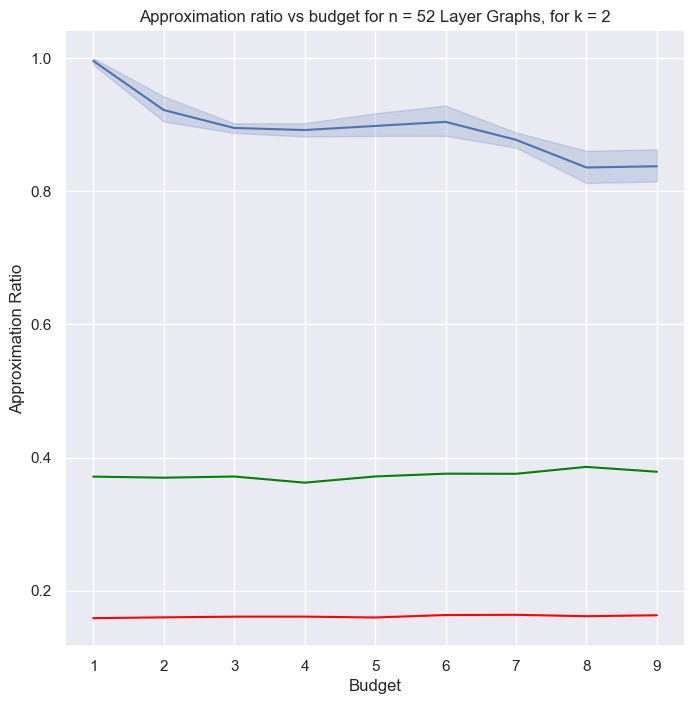

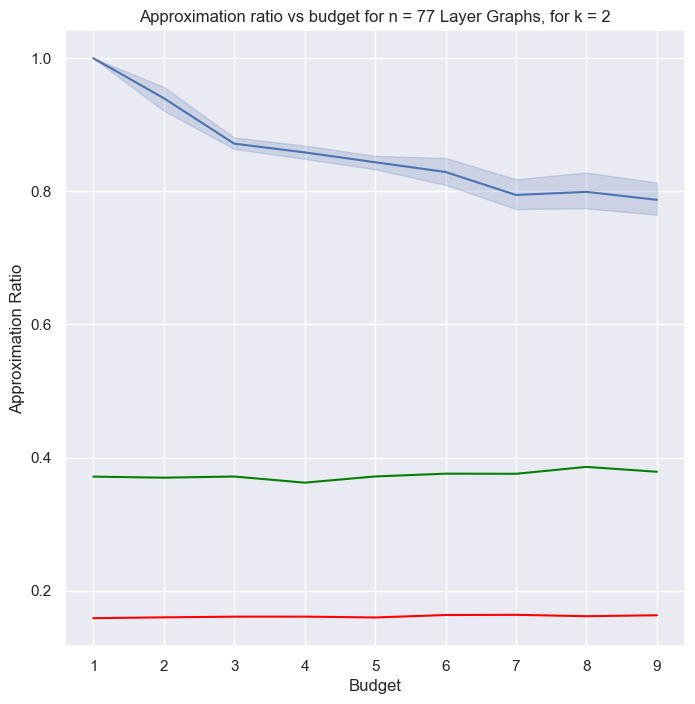

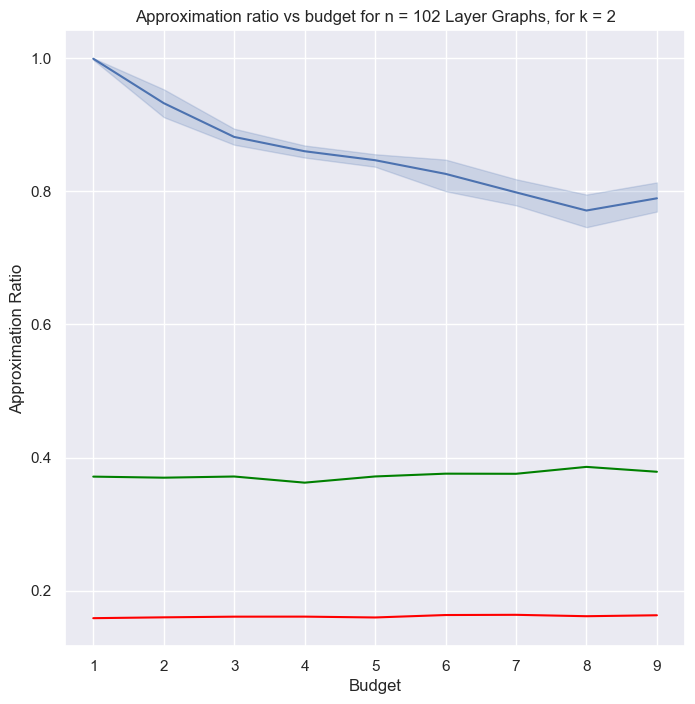

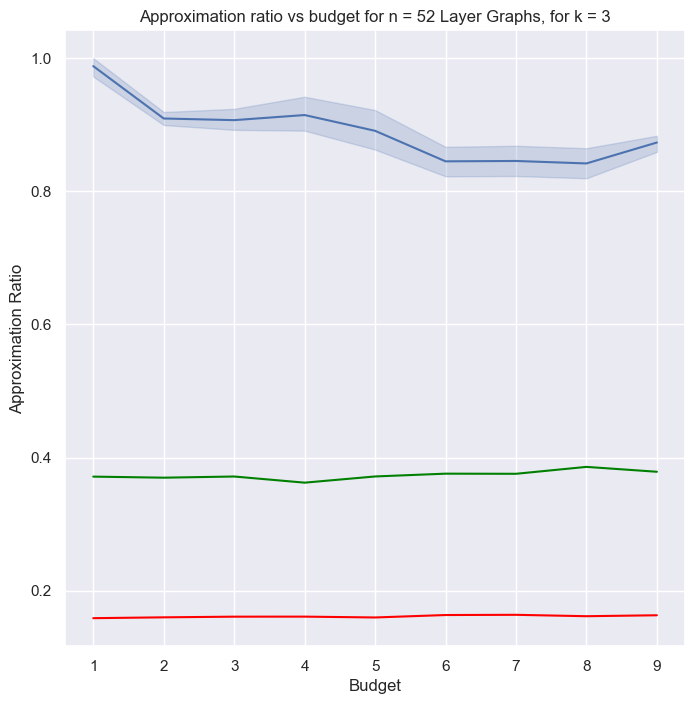

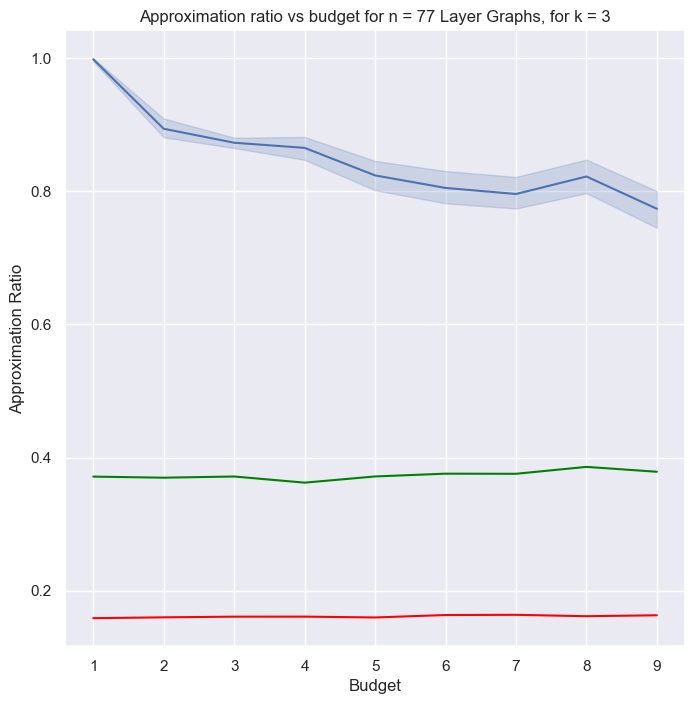

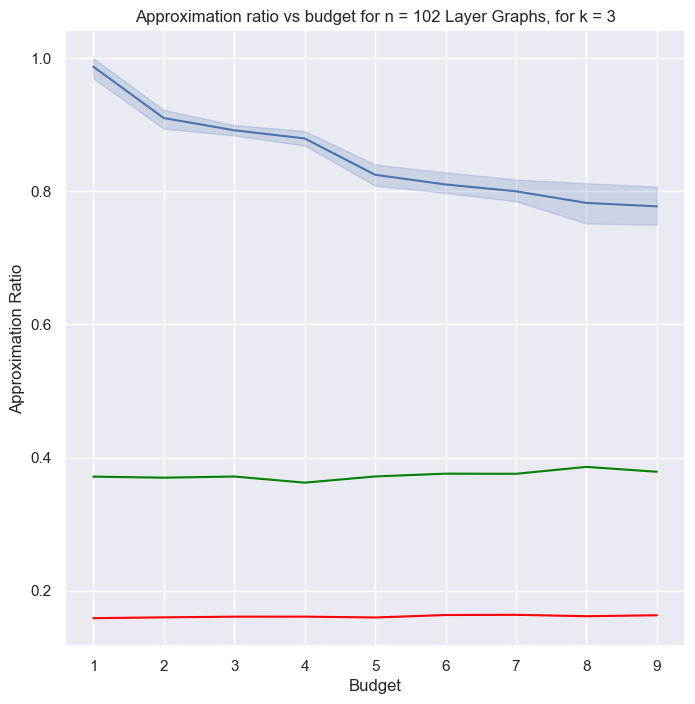

In [13]:
exp = pd.read_csv(EXP_FILE)

x_label = "Budget"
y_label = "Approximation Ratio"

for k in [2, 3]:
    k_temp = exp[exp['policies'] == k]
    for n in [52, 77, 102]:
        kn_temp = k_temp[k_temp['nodes'] == n]
        plt.figure(figsize = (8, 8))
        sns.lineplot(x="budget", y="approximation_ratio", data=kn_temp)
        sns.lineplot(x="budget", y="alpha_hat_1", data=exp, color='red', errorbar=None)
        sns.lineplot(x="budget", y="alpha_hat_2", data=exp, color='green', errorbar=None)
        
        title = "Approximation ratio vs budget for n = " + str(n) + " Layer Graphs, for k = " + str(k)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig(EXP_NAME + "-n" + str(n) + "-k" + str(k) + ".png")
    


([<matplotlib.axis.XTick at 0x15547c9a0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

<Figure size 500x500 with 0 Axes>

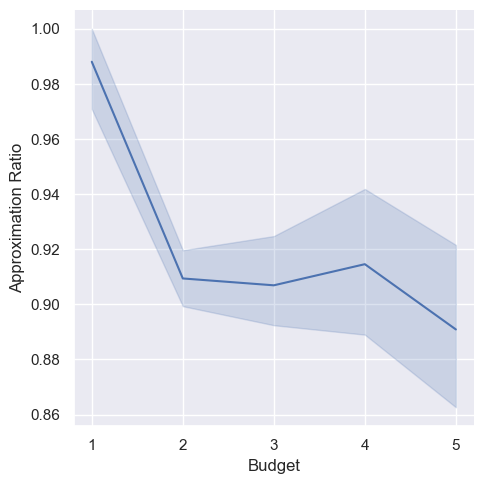

In [92]:
exp_3 = exp[exp["policies"] == 3]
max_budget = exp_3["budget"].max()
min_budget = exp_3["budget"].min()
x_list = list(range(min_budget, max_budget+1))
plt.figure(figsize = (5, 5))
sns.relplot(x="budget", y="approximation_ratio", kind="line", data=exp_3)

# title = "Approximation ratio vs condition number, for k = " + str(k)
# plt.title(title)
plt.xlabel("Budget")
plt.ylabel("Approximation Ratio")
plt.xticks(x_list)
#figure_path_png = os.path.join(figure_dir, "ratio_plot_n" + str(n) + ".png")
#plt.savefig(figure_path_png)